In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
class ChannelAttention(nn.Module):
    """Channel attention module for CBAM"""
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # Both of these pooling returns 1 value per channel. [C,1,1]
        self.max_pool = nn.AdaptiveMaxPool2d(1) # [C,1,1]

        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels//reduction, 1, bias=False), # This mixes channel info, not spatial since the kernel size is 1 [Cr, 1, 1]
            nn.ReLU(inplace=True), # Bottleneck
            nn.Conv2d(in_channels//reduction, inchannels, 1, bias=False) # [C, 1, 1]
        )
        self.sigmoid = nn.Sigmoid() # Scale 0-1 per channel

    def forward(self, x):
        max_pool = self.max_pool(x)
        avg_pool = self.avg_pool(x)
        max_out = self.fc(max_pool)
        avg_out = self.fc(avg_pool)
        out = max_out + avg_out
        return self.sigmoid(out)

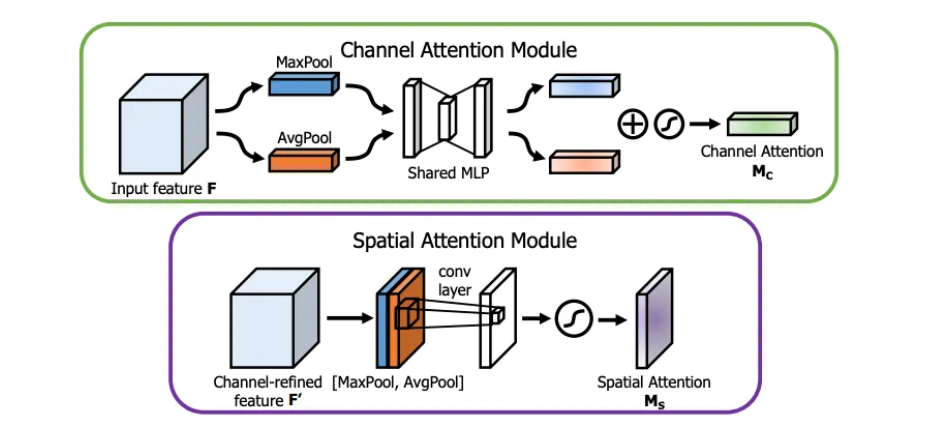

In [6]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size = 7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False) # [1, H, W]
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        max_out, _ = torch.max(x, dim=1, keepdim=True) # [1, H, W]
        avg_out = torch.mean(x, dim=1, keepdim=True) # [1, H, W]
        out = torch.cat([avg_out, max_out], dim=1) # [2, H, W]
        out = self.conv(out)
        return self.sigmoid(out)

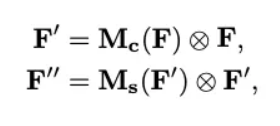  
Here Mc and Ms are Channel and Spatial Attention maps
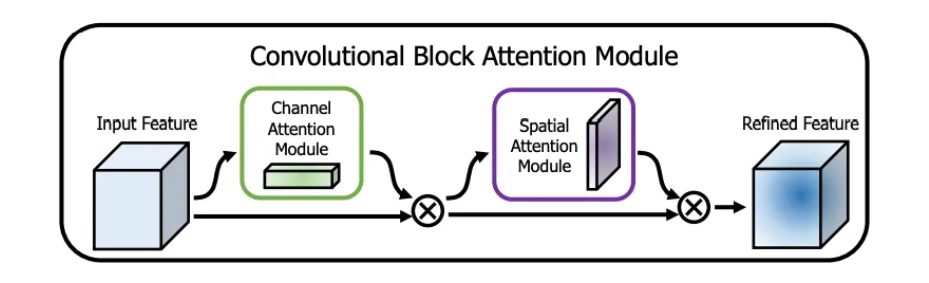

In [7]:
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x) # Channel attention and Spatial attention are applied sequentially
        x = x * self.spatial_attention(x)
        return x

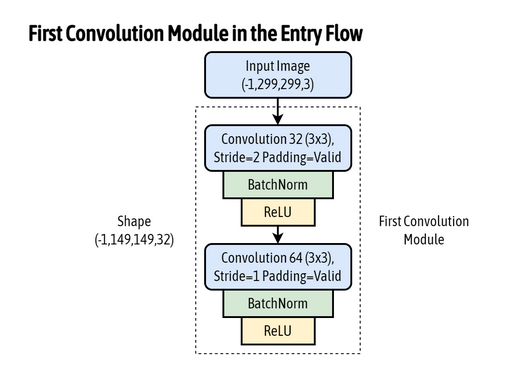

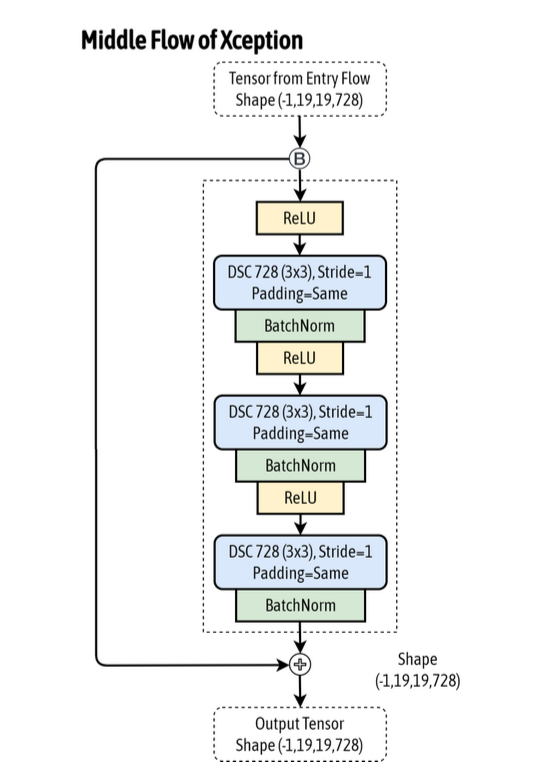

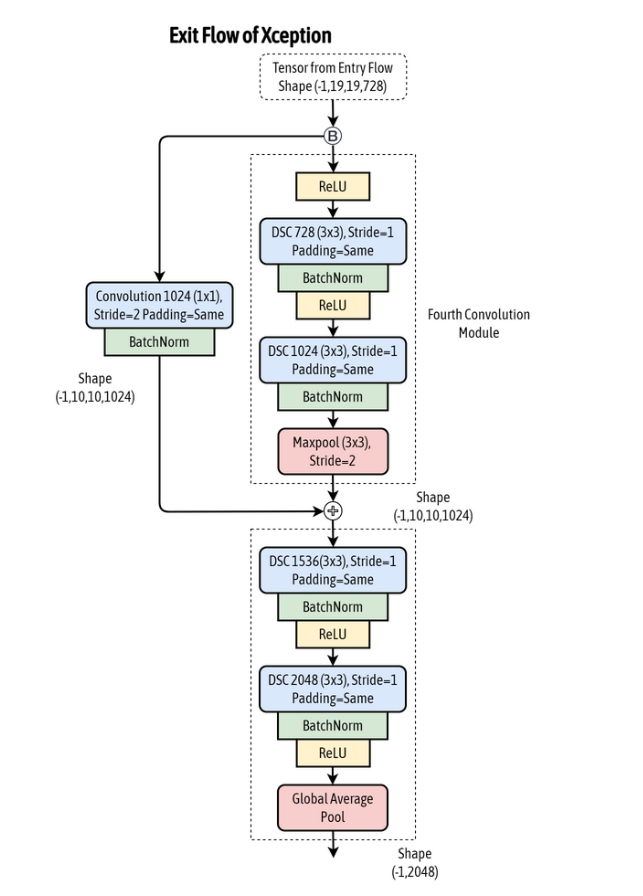

In [8]:
# Stage     Channels    Stride     Spatial-Resolution (299x299 input)    Semantic Level  
# 0          64           2               150x150                         Low-level features  
# 1          128          4               75x75                           Edges, textures  
# 2          256          8               38x38                           Patterns  
# 3          728         16               19x19                           Object parts  
# 4          2048        32               10x10                           High-level semantics  

Placing the CBAMs at the end of stage 3 and 4 gives the best balance of accuracy and speed. Since it attends to both mid-level and high-level features
Proven effective in similar architectures

In [10]:
class LearnableFusion(nn.Module):
    """Learnable fusion mechanism for combining spatial and frequency streams"""
    def __init__(self, spatial_dim, frequency_dim, fusion_dim=512):
        super(LearnableFusion, self).__init__()

        # Both streams need to be projected to the same dimension
        self.spatial_proj = nn.Sequential(    # [B, spatial_dim] -> [B, fusion_dim]
            nn.Linear(spatial_dim, fusion_dim),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.frequency_proj = nn.Sequential( # [B, frequency_dim] -> [B, fusion_dim]
            nn.Linear(frequency_dim, fusion_dim),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # Attention weights for fusion
        self.attention = nn.Sequential(
            nn.Linear(fusion_dim*2, fusion_dim), # Both feature projections are to be concatenated  [B, 2 * fusion_dim]
            nn.ReLU(),
            nn.Linear(fusion_dim, 2),
            nn.Softmax(dim=1)  # [B, 2]
        )

    def forward(self, spatial_features, frequency_features):
        # Project features
        spatial_proj = self.spatial_proj(spatial_features)
        frequency_proj = self.frequency_proj(frequency_features)

        # Concatenate the feature projections
        concat_features = torch.cat([spatial_proj, frequency_proj], dim=1)

        # Compute attention weights
        attention_weights = self.attention(concat_features) # [B, 2]

        # Weighted fusion based on the attention weights
        fused = (attention_weights[:, 0:1] * spatial_proj + attention_weights[:, 1:2] * frequency_proj)

        return fused, attention_weights

SPATIAL -> FREQUENCY

In [1]:
import numpy as np
from scipy.fftpack import dct

In [11]:
def dct2d(block):
    """Apply 2D Discrete Cosince Transform (DCT) on an image channel"""
    return dct(dct(block.T, norm="ortho").T, norm="ortho")

In [10]:
def rgb_to_dct_batch(images):
    """
    Convert a batch of RGB images to DCT domain.

    Args:
        images: torch.Tensor or np.ndarray of shape (B, 3, H, W)
                pixel values in [0, 255] or [0, 1]
    
    Returns:
        dct_images: torch.Tensor of shape (B, 3, H, W)
    """
    if isinstance(images, torch.Tensor):
        images = images.detach().cpu().numpy()
    batch_size, _, H, W = images.shape
    
    dct_batch = []
    for b in range(batch_size):
        dct_channels = []
        for c in range(3):
            # Apply DCT to each color channel
            dct_ch = dct2d(images[b, c].astype(np.float32))
            dct_channels.append(dct_ch)
        dct_batch.append(np.stack(dct_channels, axis=0))
    
    dct_batch = np.stack(dct_batch, axis=0)  # (B, 3, H, W)
    return torch.from_numpy(dct_batch).float()

In [9]:
def normalize_dct(dct_batch):
    """Normalize DCT coefficients batch-wise."""
    mean = dct_batch.mean(dim=(2,3), keepdim=True)
    std = dct_batch.std(dim=(2,3), keepdim=True)
    return (dct_batch - mean) / (std + 1e-8)

 BACKBONE NETWORKS

In [14]:
class DCTStream(nn.Module):
    """Frequency stream processing DCT features"""
    def __init__(self):
        super(DCTStream, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False)
        )
        self.cbam1 = CBAM(512)
        self.cbam2 = CBAM(512)
        self.cbam3 = CBAM(512)

        self.feature_dim = 512
        
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.conv2(x)
        x = self.cbam1(x)

        x = self.conv3(x)
        x = self.cbam2(x)

        x = self.conv4(x)
        x = self.cbam3(x)

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)

        return x

In [16]:
import timm

In [17]:
class XceptionWithCBAM(nn.Module):
    def __init__(self, pretrained=True):
        super(XceptionWithCBAM, self).__init__()
        base_model = timm.create_model('xception', pretrained=pretrained, features_only=True)
        self.stage0 = nn.Sequential(*list(base_model.children())[0:2])   # 64 channels
        self.stage1 = nn.Sequential(*list(base_model.children())[2:4])   # 128 channels
        self.stage2 = nn.Sequential(*list(base_model.children())[4:6])   # 256 channels
        self.stage3 = nn.Sequential(*list(base_model.children())[6:12])  # 728 channels
        self.stage4 = nn.Sequential(*list(base_model.children())[12:])   # 2048 channels

        self.cbam_stage3 = CBAM(728)
        self.cbam_stage4 = CBAM(2048)
        
    def forward(self, x):
        # Stage 0-2: Early feature extraction (no CBAM)
        x = self.stage0(x)  # 64 @ 150x150
        x = self.stage1(x)  # 128 @ 75x75
        x = self.stage2(x)  # 256 @ 38x38
        
        # Stage 3: Mid-level features with CBAM
        x = self.stage3(x)  # 728 @ 19x19
        x = self.cbam_stage3(x)
        
        # Stage 4: High-level features with CBAM
        x = self.stage4(x)  # 2048 @ 10x10
        x = self.cbam_stage4(x)
        
        # Global average pooling
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)  # Flatten to (batch, 2048)
        
        return x

BASELINE

In [18]:
class XceptionBaseline(nn.Module):
    def __init__(self, pretrained=True, num_classes=2):
        super(XceptionBaseline, self).__init__()
        self.xception = timm.create_model('xception', pretrained=pretrained, num_classes = 0)
        self.feature_dim = 2048

        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.xception(x)
        features = F.adaptive_avg_pool2d(features, 1).view(features.size(0), -1)
        logits = self.classifier(features)
        return logits